In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import galsim
from scipy.optimize import least_squares

## As before, here are some functions to help with the exercise.

In [2]:
def make_galaxy_image(flux=1, sersic_index=1., half_light_radius = 1.0,shear=0., angle=0.,nx=64,ny=64,offset=[0,0],add_noise = False,noise_std = 0.001,psfObj=None,pixel_scale=0.2):
    if psfObj is None:
        psfObj = galsim.Gaussian(sigma=1., flux=1.)
    galaxy = galsim.Sersic(flux=flux,n=sersic_index,half_light_radius=half_light_radius,).shear(g1 = shear).rotate(angle*galsim.degrees)
    galaxy_conv = galsim.Convolve([galaxy,psfObj])
    simImage = galaxy_conv.drawImage(scale=pixel_scale,offset=offset,nx=nx,ny=ny)
    if add_noise:
        noise = galsim.GaussianNoise(sigma=noise_std)
        noise.applyTo(simImage)
    return simImage.array

def make_galaxy_images(fluxes=[1,1],sersic_indices=[1.,1.2],half_light_radii=[4.,3.],shears=[0.,0.],angles=[0.,0.],nx=64,ny=64,offsets=[[0,0],[5,-3]],add_noise=False, noise_std = 0.001,psfObj=None,pixel_scale=0.2):
    simImage = np.zeros((nx,ny))
    for i in range(len(fluxes)):
        simImage = simImage + make_galaxy_image(flux=fluxes[i],sersic_index=sersic_indices[i],half_light_radius=half_light_radii[i],shear=shears[i],angle=angles[i],nx=nx,ny=ny,offset=offsets[i],noise_std=noise_std,add_noise=add_noise,psfObj=psfObj,pixel_scale=pixel_scale)
    return simImage

def modelResiduals(parameters,image,psf = None):
    # Get the model prediction.
    # This code is really more of a template.
    model  = 'your model here'
    return  (model - image).flatten()

def modelPhotom(image, parameters, residualsFunction,psf=None):
    '''
    Fit a parameterized model to the provided image.
    '''
    result = least_squares(residualsFunction, parameters, method='lm', args=(image,psf))#,options={'xtol':1e-12})
    return result.x

## First, construct a simulated psf-convolved galaxy, step by step.

### 1. Choose a simulated galaxy to use for our mock simulation.

### 2. Choose a model PSF to represent our optical system.

### 3. Decide on a world-coordinate system to project our galaxy onto.

### 4. Perform the PSF convolution.

### 5. Add noise.

Once you've done this, we'll build a forward-modeling forced-photometry measurement code around your model.

Then we'll explore the positive and negative features of this approach on a few different simulated cases.

At the end, the goal is to have something you can use to perform a measurement on some real data.

In [3]:
# We will choose another Sersic galaxy, shear it to provide some ellipticity , and rotate it.
ideal_galaxy = galsim.Sersic(n=1,half_light_radius=1,flux = 1.).shear(g1 = 0.2).rotate(30*galsim.degrees)

# Next, we'll specify the PSF. This has two components -- an optical and an atmospheric.
# Here GalSim is assuming the wavelength is in nm, and the diameter in m.
optical_psf = galsim.OpticalPSF(lam=600,diam=8.4,obscuration=3.4/8.4) 

# The fwhm of the Kolmogorov psf here is assumed to be in arcseconds
turb_psf = galsim.Gaussian(fwhm=0.67 ) 

# To actually say what we'd see on the chip, though, we have to provide some information about the detector!
wcs =galsim.PixelScale(0.2) # the argument expected is arcseconds/pixel.

# We're going to add some noise. Most of the noise, for most Rubin galaxies, 
#  is dominated by the sky background, which means the noise is independent of
#  the galaxy properties.

noise = galsim.GaussianNoise(sigma=0.001)

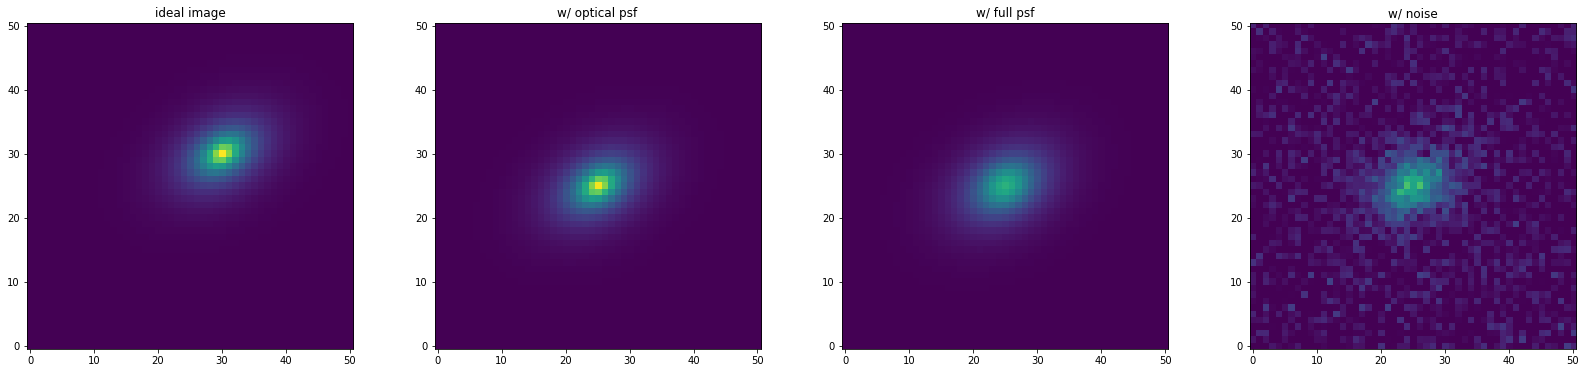

In [4]:
# First, render the ideal, pre-seeing galaxy.

true_image =ideal_galaxy.drawImage(nx=51,ny=51,wcs=wcs, offset = [5,5])

# Then show what it would look like with a Rubin-like optical PSF.
optical_image = galsim.Convolve([ideal_galaxy,optical_psf]).drawImage(nx=51,ny=51,wcs=wcs)


# Add the atmosphere.
full_psf_image = galsim.Convolve([ideal_galaxy,optical_psf,turb_psf]).drawImage(nx=51,ny=51,wcs=wcs)


# Then add noise.
noisy_image = full_psf_image.copy()
noise.applyTo(noisy_image)

# Plot these all, side-by-side.
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(28,6))
artist = ax1.imshow(true_image.array,origin='lower')
ax1.set_title("ideal image")
ax2.imshow(optical_image.array,origin='lower',norm=artist.norm)
ax2.set_title("w/ optical psf")
ax3.imshow(full_psf_image.array,origin='lower',norm=artist.norm)
ax3.set_title("w/ full psf")
ax4.imshow(noisy_image.array,origin='lower',norm=artist.norm)
ax4.set_title("w/ noise")
plt.show()

## Problem 1: Write a single function to generate model galaxies. 

It should do all of the following steps.

You're going to use this for measurement, so it should have a structure functionally equivalent that below.

Namely, it should take a _parameter vector_, which the scipy.optimize codes will vary to find a best-fit solution.
To make a model prediction, it should also take as a second argument a vector of *meta parameters*, which describe quantities that are not part of the fit, such as the dimensions of the image.

Today, you'll be trying to recover more than the flux.

Check whether your implementation of this function works be using it to generate an image that exactly matches the simulated data above (except for the noise).

In [5]:
def modelPrediction(parameters,image,psf):
    '''
    parameters should contain all and only the quantities that you will vary to fit the model to the data.
    
    meta_parameters should contain everything that is _not_ varied, such as the psf model, or the number of
    pixels in the image.
    
    As written, this function doesn't work -- you'll have to modify it.
    
    '''
    
    # You can assume any order you like for the model parameter vector, as long as 
    # you document it!
    x_center,y_center = parameters[0],parameters[1]
    flux = parameters[2]
    half_light_radius = parameters[3]
    shear = parameters[4]
    angle = parameters[5]
    
    # These meta-parameters are used to build the image, but not varied during the fit.
    nx = image.array.shape[0]
    ny = image.array.shape[1]
    image_wcs = image.wcs
    
    # Add your model for the galaxy here.
    ideal_galaxy = galsim.Sersic(n=1,half_light_radius=half_light_radius,flux = flux).shear(g1 = shear).rotate(angle*galsim.degrees)
    psf_convolved_galaxy_object = galsim.Convolve([ideal_galaxy, psf])
    psf_convolved_galaxy_image = psf_convolved_galaxy_object.drawImage(nx=nx,ny=ny,offset=[x_center,y_center],wcs=image_wcs)
    
    return psf_convolved_galaxy_image





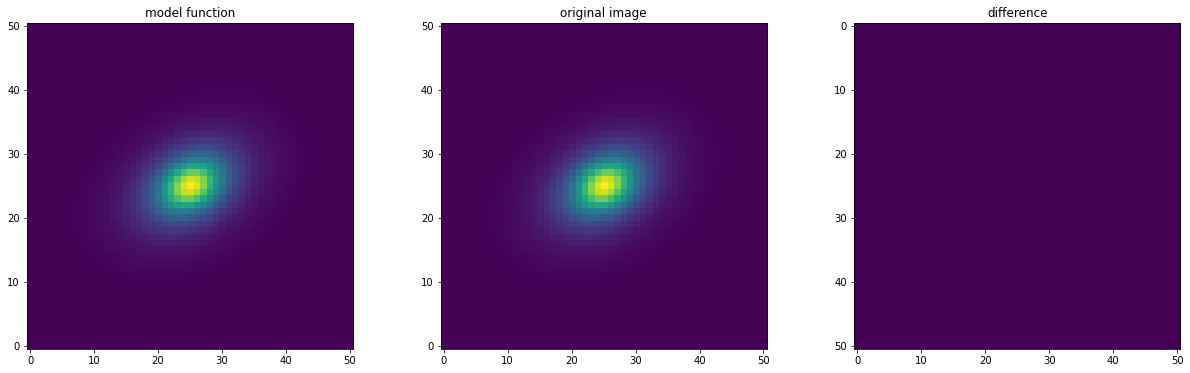

In [6]:
# Now let's see if the model image looks like the original.
parameters = [0.,0.,1.,1.,0.2,30.]
psf_model = galsim.Convolve([optical_psf,turb_psf])
model_image = modelPrediction(parameters,full_psf_image,psf_model)

fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(21,6))
artist=ax1.imshow(model_image.array,origin='lower')
ax1.set_title('model function')
ax2.imshow(full_psf_image.array,norm=artist.norm,origin='lower')
ax2.set_title('original image')
ax3.imshow((full_psf_image.array-model_image.array),norm=artist.norm)
ax3.set_title('difference')
plt.show()

## Problem 2: Now we're going to try the measurement out for a few hard cases.

Use scipy.optimize.least_squares (or your favorite alternative method) to find the best-fit parameters for some simulated galaxies.

Write a function that uses the model prediction code you've just written to fit a single, isolated galaxy image.

To do this, you'll have to write a function that takes a set of parameters, and returns a vector of the differences between the data and the model. You may find it helpful to look at some of the code I provided in yesterday's 'Simulation and Inference with GalSim' notebook.

Test it on the simulated data above.

In [7]:
'''
We can copy the functions from yesterday's exercise, with some small modifications.
GalSim's Image object keeps track of all the key properties of an image, except for the psf.
'''

def modelResiduals(parameters,image,psf):
    # Get the model prediction.
    model  = modelPrediction(parameters,image,psf)
    # Difference it from the image being fit.
    return  (model.array - image.array).flatten()


# Test this out by calculating the residuals function when we use the right parameters.

residuals = modelResiduals(parameters,full_psf_image,psf_model)
print(np.max(residuals))

5.820766e-11


### This works to fairly high precison. Now set up the fit!

success? True
when we start with some other parameters:
 starting parameters:[1.0, 1.0, 2.0, 0.5, 0.5, 0.0]
 best-fit parameters: [-6.86655003e-02  1.50040734e-02  1.00389770e+00  9.95718808e-01
  1.83729238e-01  3.00163273e+01]
 true parameters:[0.0, 0.0, 1.0, 1.0, 0.2, 30.0]


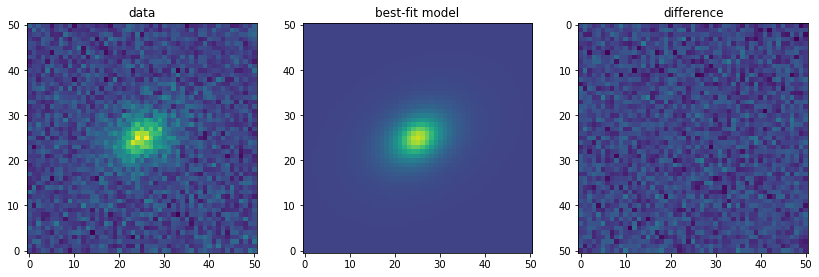

In [8]:
def modelFitter(image, starting_parameters, residualsFunction,psf):
    '''
    Fit a parameterized model to the provided image.
    least_squares (see docs) takes as its arguments the name of the residuals function,
      and a vector of starting parameters.
    '''
    result = least_squares(residualsFunction, starting_parameters, method='trf', args=(image,psf))
    print(f"success? {result.success}")
    return result.x

# Try the fit when we use _incorrect_ starting values, and the noisy version of the image.

wrong_starting_parameters = [1., 1., 2., 0.5, 0.5, 0.]
fit_parameters = modelFitter(noisy_image, wrong_starting_parameters,modelResiduals,psf=psf_model)

print("when we start with some other parameters:")
print(f' starting parameters:{wrong_starting_parameters}')
print(f' best-fit parameters: {fit_parameters}')
print(f' true parameters:{parameters}')

# Hm. These parameters don't seem quite right. 
# But since we haven't provided real errors, we don't know if they're within a 
#  reasonable uncertainty range or not.
# Let's try showing the model fit, and comparing it to the data.

best_fit_model = modelPrediction(fit_parameters,model_image,psf_model)

fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(14,6))
artist=ax1.imshow(noisy_image.array,origin='lower')
ax1.set_title('data')
ax2.imshow(best_fit_model.array,norm=artist.norm,origin='lower')
ax2.set_title('best-fit model')
ax3.imshow((best_fit_model.array-noisy_image.array),norm=artist.norm)
ax3.set_title('difference')
plt.show()

# And the difference between data and model looks like noise.

## Probem 3: Masking

Modify the likelihood function in your previous example to take a 'mask' as a meta-parameters.

Try fitting the model with mask in place, and see if you can recover the flux.

Then start increasing the fraction of masked pixels, and see how far you can go before you cannot accurately recover the flux.

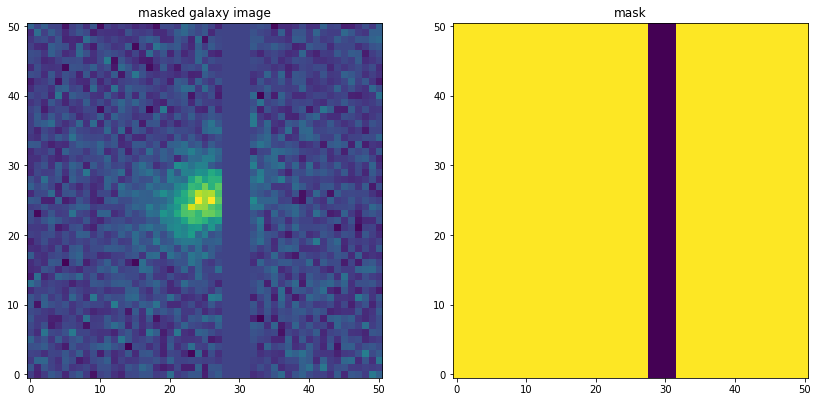

In [9]:
masked_image = noisy_image.array.copy()
mask = np.ones_like(masked_image)
mask[:,28:32] = 0
masked_image[mask==0] = 0


fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(14,7))
ax1.imshow(masked_image,origin='lower')
ax1.set_title("masked galaxy image")
ax2.imshow(mask,origin='lower')
ax2.set_title("mask")
plt.show()

success? True
true flux: 1.0
recovered flux: 0.9988988031666062


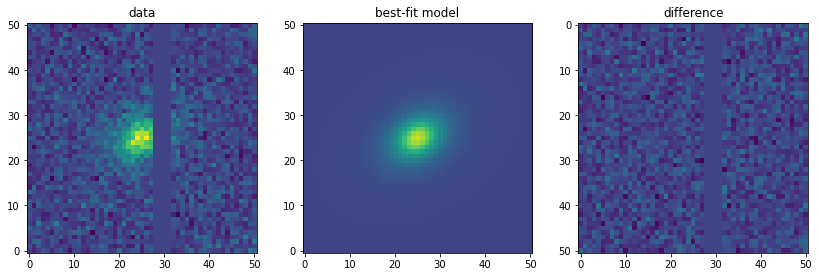

In [10]:
def modelResidualsWithMask(parameters,image,psf,mask=None):
    # Get the model prediction.
    model  = modelPrediction(parameters,image,psf)
    # Difference it from the image being fit.
    if mask is not None:
        difference = (model.array - image.array)[mask>0].flatten()
    else:
        difference = (model.array - image.array).flatten()

    return  difference

def modelFitterWithMask(image, starting_parameters, residualsFunction,psf,mask=None):
    '''
    Fit a parameterized model to the provided image.
    least_squares (see docs) takes as its arguments the name of the residuals function,
      and a vector of starting parameters.
    It may be helpful to leave the mask as an optional argument.
    '''
    result = least_squares(residualsFunction, starting_parameters, method='trf', args=(image,psf,mask))
    print(f"success? {result.success}")
    return result.x

# Create an image object.
masked_imageobj = galsim.Image(masked_image,wcs=model_image.wcs)

wrong_starting_parameters = [0., 0., 2., 1.1, 0.2, 0.]
best_fit_parameters_with_mask = modelFitterWithMask(masked_imageobj, wrong_starting_parameters,modelResidualsWithMask,psf_model,mask)
best_fit_model_with_mask = modelPrediction(best_fit_parameters_with_mask,masked_imageobj,psf_model)

print(f"true flux: {1.}")
print(f"recovered flux: {best_fit_parameters_with_mask[2]}")

fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(14,6))
artist=ax1.imshow(masked_imageobj.array,origin='lower')
ax1.set_title('data')
ax2.imshow(best_fit_model_with_mask.array,norm=artist.norm,origin='lower')
ax2.set_title('best-fit model')
ax3.imshow((masked_imageobj.array-best_fit_model_with_mask.array*mask),norm=artist.norm)
ax3.set_title('difference')
plt.show()


## Problem 4: Blending

This is a *pair* of galaxies, which overlap but are clearly distinguishable.

Modify your model-fitting code to handle parameters for both of them.

Note: If everything works, but you're having trouble getting the fits to converge, try simplifying things by simulating and fitting only _round_ galaxies.

Do the fits improve if you don't have to fit for the center positions?

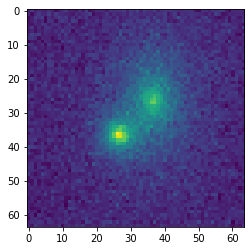

In [11]:
psf = galsim.Airy(lam=500,diam=2.5)
blended_image = make_galaxy_images(fluxes=[2.,10.],sersic_indices=[1.,1.2],half_light_radii=[1.,3.],shears=[0.,0.2],angles=[0.,90.],nx=64,ny=64,offsets=[[-5,5],[5,-5]],add_noise=True, noise_std = 0.001,psfObj=psf,pixel_scale=0.2)
plt.imshow(blended_image)
plt.show()

In [12]:
# It's helpful here to start by recasting the image as a GalSim image object.
blended_imageObj = galsim.Image(blended_image,wcs=wcs)

# Start by writing a new residuals function.

def modelResidualsTwoSources(parameters,image,psfmodel,mask=None):
    # We're going to fit two galaxies here.
    # The given parameters should cover both.
    #  We simply have to choose here how to arrange them.
    first_galaxy_parameters = parameters[:6]
    second_galaxy_parameters = parameters[6:]
    
    first_galaxy_model  = modelPrediction(first_galaxy_parameters,image,psfmodel)
    second_galaxy_model = modelPrediction(second_galaxy_parameters,image,psfmodel)
    model = first_galaxy_model + second_galaxy_model
    # Difference it from the image being fit.
    if mask is not None:
        difference = (model.array - image.array)[mask>0].flatten()
    else:
        difference = (model.array - image.array).flatten()

    return  difference

# It will turn out that, since this new model is very complex, we will have to
#  enforce some bounds on the parameters (the shear cannot go above 1.)
# This requires a slight modification to the fitter.

def modelFitterWithMaskAndBounds(image, starting_parameters, residualsFunction,psfmodel,mask=None,bounds=None):
    '''
    Fit a parameterized model to the provided image.
    least_squares (see docs) takes as its arguments the name of the residuals function,
      and a vector of starting parameters.
    It may be helpful to leave the mask as an optional argument.
    '''
    result = least_squares(residualsFunction, starting_parameters, method='trf', bounds=bounds,args=(image,psfmodel,mask))
    print(f"success? {result.success}")
    return result.x


In [13]:
# Reprinting the parameter order:
'''
x_center,y_center = parameters[0],parameters[1] # These should not go above or below +/-25
flux = parameters[2]
half_light_radius = parameters[3]
shear = parameters[4] # This cannot go above or below +/-1
angle = parameters[5]
'''


double_starting_parameters = [-5.1, 4.9, 2.3, 1.05, 0.1, 0.,5., -5., 10., 3., 0.2, 0.]
lower_bounds = [-50,-50,0,0,-1.,-np.inf ,-50,-50,0,0,-1.,-np.inf ]
upper_bounds = [50,50,np.inf,np.inf,1.,np.inf ,50,50,np.inf,np.inf,1.,np.inf ]
parameter_bounds = (lower_bounds,upper_bounds)

best_fit_parameters_double = modelFitterWithMaskAndBounds(blended_imageObj, double_starting_parameters,modelResidualsTwoSources,psf,bounds=parameter_bounds)


print(f"best fit fluxes: {best_fit_parameters_double[2],best_fit_parameters_double[8]}")
print(f"true fluxes: {2.0,10.0}")

success? True
best fit fluxes: (2.1710362759706445, 9.865187510383947)
true fluxes: (2.0, 10.0)


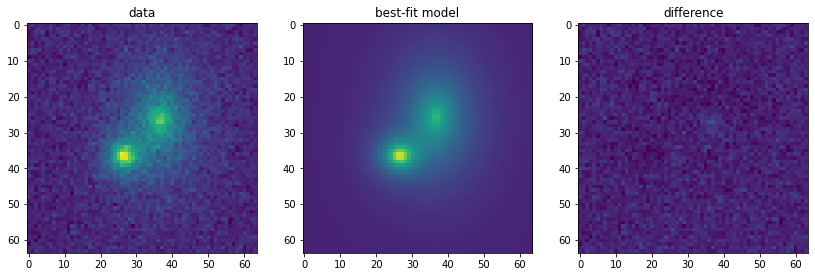

In [14]:
# Now let's inspect the results and compare to the data.

first_galaxy_parameters = best_fit_parameters_double[:6]
second_galaxy_parameters = best_fit_parameters_double[6:]

first_galaxy_model  = modelPrediction(first_galaxy_parameters,blended_imageObj,psf)
second_galaxy_model = modelPrediction(second_galaxy_parameters,blended_imageObj,psf)
best_fit_model_blended = first_galaxy_model + second_galaxy_model
    
    
fig,(ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(14,6))
artist=ax1.imshow(blended_imageObj.array)
ax1.set_title('data')
ax2.imshow(best_fit_model_blended.array,norm=artist.norm)
ax2.set_title('best-fit model')
ax3.imshow((blended_imageObj.array-best_fit_model_blended.array),norm=artist.norm)
ax3.set_title('difference')
plt.show()